In [1]:
%load_ext ipydex.displaytools
import sympy as sp
from sympy import sin, cos
import numpy as np
import symbtools as st
import matplotlib.pyplot as plt
sp.init_printing()

In [2]:
theta1, theta2, theta3 = theta = st.symb_vector('theta1:4')

In [3]:
b1 = sp.Matrix([0, 0])
b2 = sp.Matrix([1, 0])
p1 = b1 + sp.Matrix([cos(theta1), sin(theta1)])
p2 = p1 + sp.Matrix([cos(theta1+theta2), sin(theta1+theta2)])
p3 = b2 + sp.Matrix([cos(theta3), sin(theta3)])

In [4]:
from ipywidgets import FloatSlider, interact

class VisualiserElement:
    def __init__(self, points_fun, init_fun, update_fun, axis, kwargs):
        self.points_fun = points_fun
        self.init_fun = init_fun
        self.update_fun = update_fun
        self.axis = axis
        self.kwargs = kwargs
        self.drawables = []
        
class Visualiser:
    def __init__(self, variables, default_axis=None):
        self.variables = variables
        self.elements = []        
        self.default_axis = default_axis
        
    def create_default_axis(self):
        fig = plt.figure()
        ax = plt.axes()
        ax.set_aspect('equal')
        ax.set_xlim([-2.0, 2.0])
        ax.set_ylim([-2.0, 2.0])
        ax.grid()
        
        return ax
    
    def get_or_create_default_axis_if_necessary(self):
        if self.default_axis is None:
            if any([element.axis is None for element in self.elements]):
                default_axis = self.create_default_axis()
            else:
                default_axis = None
        else:
            default_axis = self.default_axis
            
        return default_axis
    
    def plot(self, variables_values):
        assert len(self.variables) == len(variables_values), f"You need to pass as many variable values as this visualiser has variables. Required: {len(self.variables)}, Given: {len(variables_values)}"
        
        default_axis = self.get_or_create_default_axis_if_necessary()
            
        self.plot_init(variables_values, default_axis)
        self.plot_update(variables_values, default_axis)
            
    def plot_init(self, variables_values, default_axis):
        drawables = []
        for element in self.elements:
            if element.axis is None:
                ax = default_axis
            else:
                ax = element.axis
            element.drawables = element.init_fun(ax, element.points_fun(*variables_values), element.kwargs)
            drawables += element.drawables
            
        return drawables
    
    def plot_update(self, variables_values, default_axis):
        drawables = []
        for element in self.elements:
            if element.axis is None:
                ax = default_axis
            else:
                ax = element.axis
            element.drawables = element.update_fun(ax, element.drawables, element.points_fun(*variables_values), element.kwargs)
            drawables += element.drawables
        
        return drawables
            
    def interact(self, **kwargs):
        widget_dict = dict()
        
        for var in self.variables:
            var_str = repr(var)
            if var_str in kwargs:
                widget_dict[var_str] = kwargs[var_str]
            else:
                widget_dict[var_str] = F(-5.0, 5.0, 0.1, 0.0)
        
        interact(self.interact_fun, **widget_dict)
        
    def interact_fun(self, **kwargs):
            variables_values = [kwargs[repr(var_symbol)] for var_symbol in self.variables]
            self.plot(variables_values)
        
    def add_element(self, points, init_fun, update_fun, axis=None, **kwargs):
        if not isinstance(points, sp.Matrix):
            if isinstance(points, list):
                points = st.col_stack(*points)
            else:
                raise Exception("'points' must be a SymPy matrix or a list of column vectors")
            
        points_fun = sp.lambdify(self.variables, points)
        self.elements.append(VisualiserElement(points_fun, init_fun, update_fun, axis, kwargs))
        
def init_linkage(ax, points, kwargs):
    return ax.plot(points[0, :], points[1, :], "-o", **kwargs)

def update_linkage(ax, drawables, points, kwargs):
    drawables[0].set_data(points)
    return drawables

def init_polygon(ax, points, kwargs):
    poly = plt.Polygon(points.T, **kwargs)
    ax.add_patch(poly)
    
    return [poly]

def update_polygon(ax, drawables, points, kwargs):
    poly = drawables[0]
    poly.set_xy(points.T)
    
    return drawables

def add_linkage(visualiser, points, axis=None, **kwargs):
    visualiser.add_element(points, init_linkage, update_linkage, axis, **kwargs)
    
def F(min, max, step, value):
    return FloatSlider(min=min, max=max, step=step, value=value)

In [5]:
vis = Visualiser(theta)
add_linkage(vis, [b1, p1, p2], lw=3)
add_linkage(vis, [b2, p3], lw=3)
vis.add_element([b1, p2, p3], init_polygon, update_polygon, alpha=0.5)

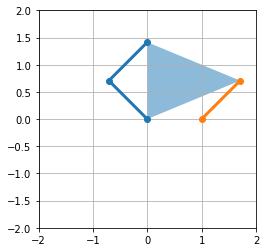

In [6]:
vis.plot([3*np.pi/4, -np.pi/2, np.pi/4])

In [7]:
vis.interact(theta3=F(-0.5, 0.5, 0.05, 0.5))

interactive(children=(FloatSlider(value=0.0, description='theta1', max=5.0, min=-5.0), FloatSlider(value=0.0, …